<a href="https://colab.research.google.com/github/zenon10/POC-OCR/blob/main/NER_rg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Option 1
https://www.freecodecamp.org/news/getting-started-with-ner-models-using-huggingface/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! git clone https://github.com/zenon10/POC-OCR

fatal: destination path 'POC-OCR' already exists and is not an empty directory.


In [ ]:
!pip install datasets
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikiann", "bn")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
label_names = dataset["train"].features["ner_tags"].feature.names

In [ ]:
#How to Preprocess the Dataset
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

#Get the values for input_ids, token_type_ids, attention_mask
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True)
  #tokenized_samples is not a datasets object so this alone won't work with Trainer API, hence map is used 
  #so the new keys [input_ids, labels (after adjustment)]
  #can be added to the datasets dict for each train test validation split
  total_adjusted_labels = []
  print(len(tokenized_samples["input_ids"]))
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []
   
    for wid in word_ids_list:
      if(wid is None):
        adjusted_label_ids.append(-100)
      elif(wid!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = wid
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])
        
    total_adjusted_labels.append(adjusted_label_ids)
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
#Set Up Integration for Weights and Biases
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import wandb
os.environ["WANDB_API_KEY"]="929b46c4abde3e31a2efcf8ebb022177b97c80e1"
os.environ["WANDB_ENTITY"]="Suchandra"
os.environ["WANDB_PROJECT"]="finetune_bert_ner"

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
!pip install seqeval
from datasets import load_metric
metric = load_metric(path = "seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    for k in results.keys():
      if(k not in flattened_results.keys()):
        flattened_results[k+"_f1"]=results[k]["f1"]

    return flattened_results

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-9-ad78fae2fdcd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(path = "seqeval")


In [ ]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(label_names))
training_args = TrainingArguments(
    output_dir="./fine_tune_bert_output",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_steps = 1000,
    report_to="wandb",
    run_name = "ep_10_tokenized_11",
    save_strategy='no'
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
wandb.finish()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Problem at: /usr/local/lib/python3.8/dist-packages/transformers/integrations.py 721 setup


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 1108, in init
    run = wi.init()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 713, in init
    result = run_init_handle.wait(
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/lib/mailbox.py", line 271, in wait
    raise MailboxError("transport failed")
wandb.errors.MailboxError: transport failed
wandb: ERROR Abnormal program exit


Exception: ignored

## option 2
https://towardsdatascience.com/19-entities-for-104-languages-a-new-era-of-ner-with-the-deeppavlov-multilingual-bert-1bfa6d413ea6

In [ ]:
import sys
!{sys.executable} -m pip install --user deeppavlov

In [ ]:
!pip install pytorch-crf

In [ ]:
from torchcrf import CRF

In [ ]:
from deeppavlov import configs, build_model

ner_model = build_model(configs.ner.ner_ontonotes_bert_mult, download=True)

In [ ]:
ner_model(['Business Publications \n Le Contrat de Vente International '])

In [ ]:
ner_model(["Business Publications \n Le Contrat de Vente International est utilisé par des sociétés implantées dans différents pays pour la vente et l’achat de marchandises. L’exportateur (vendeur) s'engage à livrer certains produits et l’importateur (acheteur) s'engage à les acquérir dans les conditions de paiement" ])

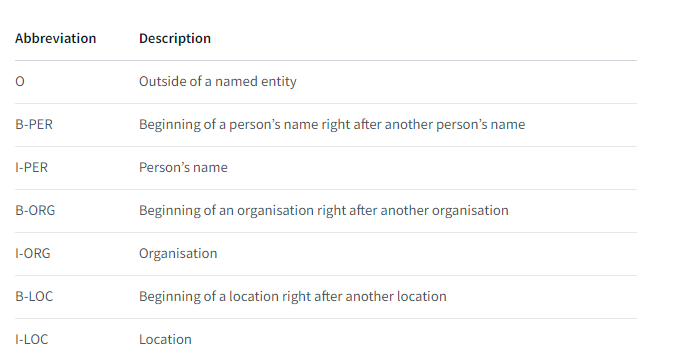

## Option 3
https://medium.com/@andrewmarmon/fine-tuned-named-entity-recognition-with-hugging-face-bert-d51d4cb3d7b5

In [ ]:
!git clone https://github.com/leslie-huang/UN-named-entity-recognition

In [ ]:
directory= '/content/UN-named-entity-recognition/tagged-training'
df = pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
df.head()

In [ ]:
!pip install transformers
!pip install datasets
!pip install seqeval

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

label_list = ['O','B-MISC','I-MISC','B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC']
label_encoding_dict = {'I-PRG': 2,'I-I-MISC': 2, 'I-OR': 6, 'O': 0, 'I-': 0, 'VMISC': 0, 'B-PER': 3, 'I-PER': 4, 'B-ORG': 5, 'I-ORG': 6, 'B-LOC': 7, 'I-LOC': 8, 'B-MISC': 1, 'I-MISC': 2}

task = "ner" 
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def get_all_tokens_and_ner_tags(directory):
    return pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
    
def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split('\t')[0] for x in y] for y in split_list]
        entities = [[x.split('\t')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})
  
def get_un_token_dataset(train_directory, test_directory):
    train_df = get_all_tokens_and_ner_tags(train_directory)
    test_df = get_all_tokens_and_ner_tags(test_directory)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return (train_dataset, test_dataset)

train_dataset, test_dataset = get_un_token_dataset('./UN-named-entity-recognition/tagged-training/', './UN-named-entity-recognition/tagged-test/')

In [ ]:
train_dataset

In [ ]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)

In [ ]:
train_tokenized_datasets

Each token has now been transformed into a numeric representation and each label has been mapped to those used in upstream training, all in Hugging Face data format.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=1e-5,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    
trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
trainer.save_model('un-ner.model')

In [ ]:
!wandb login --relogin '929b46c4abde3e31a2efcf8ebb022177b97c80e1'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

paragraph = '''Before proceeding further, I should like to inform members that action on draft resolution iv, entitled situation of human rights of Rohingya Muslims and other minorities in Myanmar is postponed to a later date to allow time for the review of its programme budget implications by the fifth committee. The assembly will take action on draft resolution iv as soon as the report of the fifth committee on the programme budget implications is available. I now give the floor to delegations wishing to deliver explanations of vote or position before voting or adoption.'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))
preds = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
preds = torch.argmax(preds.logits.squeeze(), axis=1)
predictions = [label_list[i] for i in preds]

words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')